# Building a CNN

In [1]:
from pathlib import Path
import pandas as pd
# import numpy as np
import torch
from torch.utils.data import DataLoader
from plotnine import *
%load_ext autoreload
%autoreload 2

In [2]:
from src.data.dataset import CnvDataset, CnvMemoryDataset

In [104]:
# global variables
MODEL_NAME = 'ModChrCNN_test'
BATCH = '2'
EPOCHS = 100
INCLUDE_DNA = False
INCLUDE_ATAC = True
INCLUDE_CNV = True
SEQ_LEN = 10_000
IN_DIM = len(CnvDataset._subset_embedding_rows(
    dna=INCLUDE_DNA, atac=INCLUDE_ATAC, cnv=INCLUDE_CNV
    ))
OUT_DIM = 1
print('CNN training script running for batch {}'.format(BATCH))
assert BATCH in ('1', '2'), 'Batch number not known: {}'.format(BATCH)

CNN training script running for batch 2


In [4]:
# paths
git_root = Path('.')
data_root = git_root / 'data'
assert data_root.exists(), \
    'Data directory not found!\n{} does not exist'.format(data_root.absolute())
model_path = git_root / 'model'
assert model_path.is_dir(), 'Directory for saving models does not exist'
plot_path = git_root / 'out' / 'plots' / 'cnn_training'
if not plot_path.exists():
    plot_path.mkdir(parents=True)
tb_log_path = Path('log') / 'tensorboard'
assert tb_log_path.is_dir(), 'Tensorboard logging directory does not exist!'

In [105]:
# read dataset
batch_name = 'batch_' + BATCH
train_data_root = data_root / 'embeddings' / batch_name / 'train'
assert train_data_root.is_dir(), \
    'Training data not found: "{}" not a directory'.format(train_data_root)
val_data_root = data_root / 'embeddings' / batch_name / 'val'
assert val_data_root.is_dir(), \
    'Training data not found: "{}" not a directory'.format(val_data_root)

train_df = pd.read_csv(
    data_root / 'splits' / 'batch{}_training_filtered.tsv'.format(BATCH),
    sep='\t'
    ) #.head(700)
train_dataset = CnvMemoryDataset(
    root=train_data_root, data_df=train_df, include_dna=INCLUDE_DNA,
    include_atac=INCLUDE_ATAC, include_cnv=INCLUDE_CNV
    )
print('Batch {} train loaded: {} data points'.format(BATCH, len(train_dataset)))

val_df = pd.read_csv(
    data_root / 'splits' / 'batch{}_val_filtered.tsv'.format(BATCH), sep='\t'
    ) #.head(100)
val_dataset = CnvMemoryDataset(
    root=val_data_root, data_df=val_df, include_dna=INCLUDE_DNA,
    include_atac=INCLUDE_ATAC, include_cnv=INCLUDE_CNV
    )
print('Batch {} val loaded: {} data points'.format(BATCH, len(val_dataset)))

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in data/embeddings/batch_2/train/single_gene_barcode!
Batch 2 train loaded: 20661 data points
Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in data/embeddings/batch_2/val/single_gene_barcode!
Batch 2 val loaded: 3177 data points


In [106]:
# hyper parameters
hparams = {
    'batch_size': 32,
    'epochs': EPOCHS,
    'lr': 1e-4,
    'in_dim': IN_DIM
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [107]:
# define dataloaders
batch_size = hparams.get('batch_size', 32)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## Model selection
Select the model to train here.

In [119]:
from src.network.chromosome_cnn import ChromosomeCNN, ModifiedChromosomeCNN
from src.network.simple_nn import SimpleCNN, DeepCNN
from src.network.promoter_nn import PromoterCNN

In [109]:
x1, y1 = next(iter(train_loader))
x1.size()

torch.Size([32, 3, 10000])

In [110]:
y1.size()

torch.Size([32, 1])

In [120]:
# define model
# cnn_model = PromoterCNN(hparams=hparams)
cnn_model = ModifiedChromosomeCNN(input_dim=IN_DIM, seq_len=SEQ_LEN, output_dim=OUT_DIM)

In [121]:
y1_hat = cnn_model(x1)
y1_hat

tensor([[-4.0957e-02],
        [-1.8106e-01],
        [-4.0957e-02],
        [-1.8106e-01],
        [-1.0189e-01],
        [ 3.4526e-03],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02],
        [-2.1104e-02],
        [-4.0957e-02],
        [ 2.5854e-06],
        [-4.0957e-02],
        [-4.0957e-02],
        [-1.8106e-01],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.1050e-02],
        [-1.8106e-01],
        [-1.0189e-01],
        [-2.1904e-01],
        [-4.0957e-02],
        [-1.2853e-01],
        [-4.0957e-02],
        [-1.8106e-01],
        [-4.0957e-02],
        [-4.0957e-02],
        [-4.0957e-02]], grad_fn=<AddmmBackward0>)

In [113]:
from torchviz import make_dot

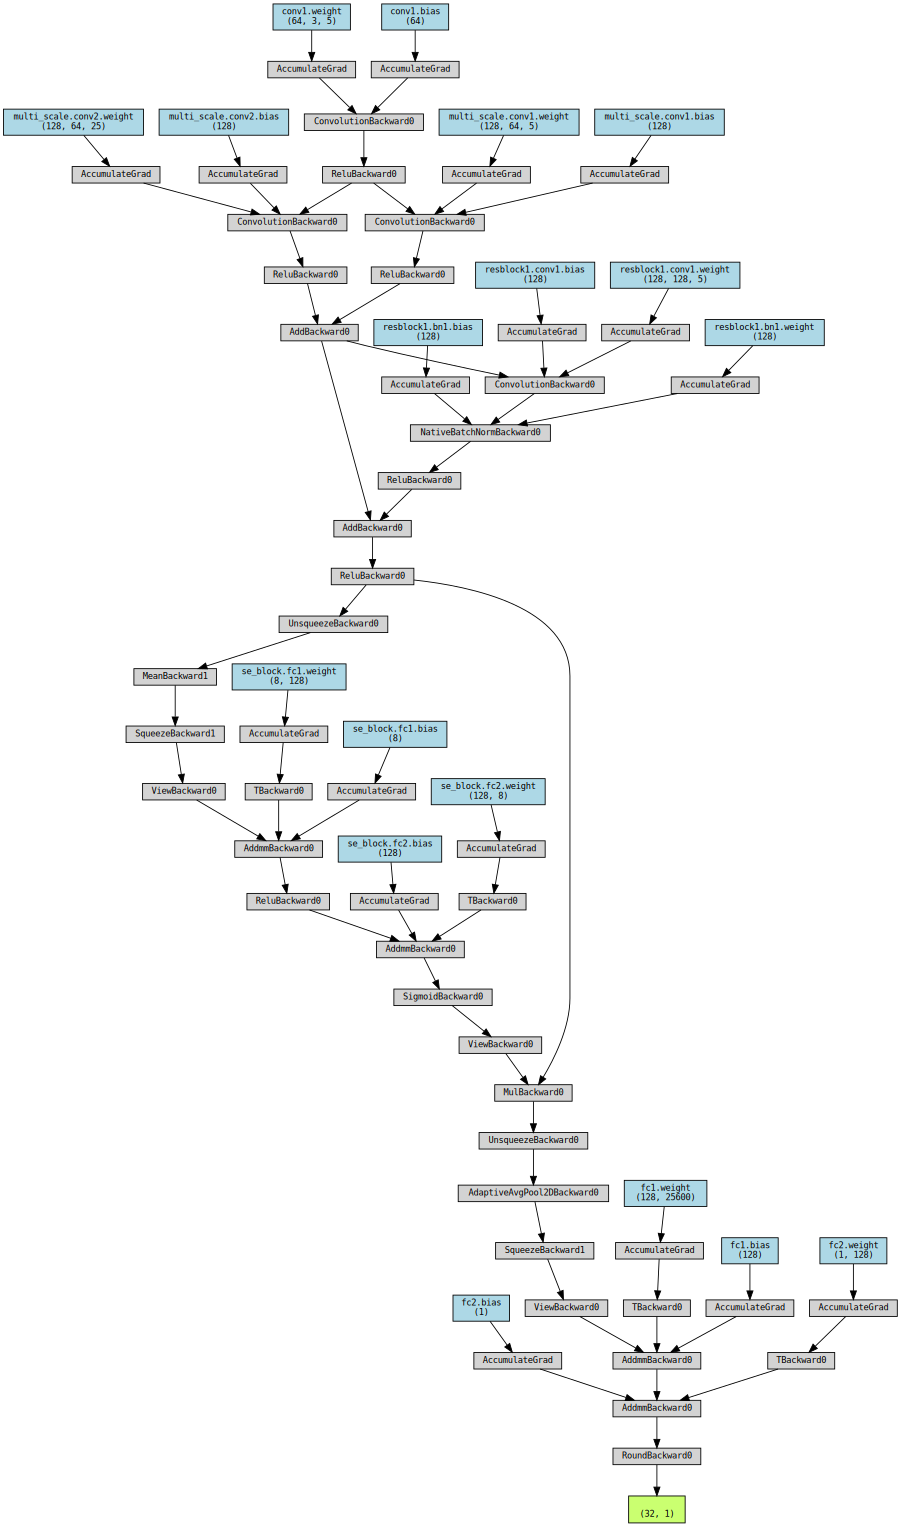

In [114]:
make_dot(y1_hat.round(), params=dict(cnn_model.named_parameters()))

In [115]:
tb_log_path = Path('log') / 'tensorboard'
assert tb_log_path.is_dir(), 'Tensorboard logging directory does not exist!'
model_name = '_'.join([MODEL_NAME, 'batch' + BATCH])
if not INCLUDE_DNA:
    model_name += '_noDNA'
if not INCLUDE_ATAC:
    model_name += '_noATAC'
if not INCLUDE_CNV:
    model_name += '_noCNV'
# define tensorboard logger
from torch.utils.tensorboard import SummaryWriter
run_number = len([
    d for d in tb_log_path.iterdir() \
        if d.is_dir() and d.name.startswith(model_name)
    ])
model_name = '_'.join([model_name, 'run' + str(run_number)])
tb_log_path = tb_log_path / model_name
tb_logger = SummaryWriter(tb_log_path)


In [116]:
model_name

'ModChrCNN_test_batch2_noDNA_run0'

In [117]:
# define training function
from src.network.training import train_model
model_dir = model_path / '_'.join([MODEL_NAME, 'batch' + BATCH])
if not model_dir.exists():
    model_dir.mkdir()

In [122]:
avg_val_loss, best_model = train_model(
    model=cnn_model, hparams=hparams, train_loader=train_loader,
    val_loader=val_loader, tb_logger=tb_logger, device=device,
    model_path=model_dir, model_name=model_name, plot_path=plot_path
)

Training Epoch [1/100]:   0%|                                                                                                 | 0/645 [00:00<?, ?it/s]

Training Epoch [1/100]:   1%|▎                                          | 5/645 [01:17<2:44:55, 15.46s/it, train_loss=0.72832286, val_loss=0.00000000]


KeyboardInterrupt: 